In [79]:
#Importing libraries
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score,recall_score,f1_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
import kerastuner as kt
import joblib
import json

In [80]:
#Reading training data
weather=pd.read_csv('Weather Training Data.csv')
weather.head(10)

,row ID,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Row0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0
1,Row1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0
2,Row2,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0
3,Row3,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,0
4,Row4,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,0
5,Row5,Albury,13.1,30.1,1.4,NaN,NaN,W,28.0,S,...,58.0,27.0,1007.0,1005.7,NaN,NaN,20.1,28.2,Yes,0
6,Row6,Albury,13.4,30.4,0.0,NaN,NaN,N,30.0,SSE,...,48.0,22.0,1011.8,1008.7,NaN,NaN,20.4,28.8,No,1
7,Row7,Albury,15.9,21.7,2.2,NaN,NaN,NNE,31.0,NE,...,89.0,91.0,1010.5,1004.2,8.0,8.0,15.9,17.0,Yes,1
8,Row8,Albury,12.6,21.0,3.6,NaN,NaN,SW,44.0,W,...,65.0,43.0,1001.2,1001.8,NaN,7.0,15.8,19.8,Yes,0
9,Row9,Albury,9.8,27.7,NaN,NaN,NaN,WNW,50.0,NaN,...,50.0,28.0,1013.4,1010.3,0.0,NaN,17.3,26.2,NaN,0


In [81]:
#Information about data
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99516 entries, 0 to 99515
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   row ID         99516 non-null  object 
 1   Location       99516 non-null  object 
 2   MinTemp        99073 non-null  float64
 3   MaxTemp        99286 non-null  float64
 4   Rainfall       98537 non-null  float64
 5   Evaporation    56985 non-null  float64
 6   Sunshine       52199 non-null  float64
 7   WindGustDir    92995 non-null  object 
 8   WindGustSpeed  93036 non-null  float64
 9   WindDir9am     92510 non-null  object 
 10  WindDir3pm     96868 non-null  object 
 11  WindSpeed9am   98581 non-null  float64
 12  WindSpeed3pm   97681 non-null  float64
 13  Humidity9am    98283 non-null  float64
 14  Humidity3pm    97010 non-null  float64
 15  Pressure9am    89768 non-null  float64
 16  Pressure3pm    89780 non-null  float64
 17  Cloud9am       61944 non-null  float64
 18  Cloud3

In [82]:
#verifying percentage of missing values
weather.isnull().mean()*100

row ID            0.000000
Location          0.000000
MinTemp           0.445155
MaxTemp           0.231119
Rainfall          0.983761
Evaporation      42.737851
Sunshine         47.547128
WindGustDir       6.552715
WindGustSpeed     6.511516
WindDir9am        7.040074
WindDir3pm        2.660879
WindSpeed9am      0.939547
WindSpeed3pm      1.843925
Humidity9am       1.238997
Humidity3pm       2.518188
Pressure9am       9.795410
Pressure3pm       9.783351
Cloud9am         37.754733
Cloud3pm         40.196551
Temp9am           0.616986
Temp3pm           1.913260
RainToday         0.983761
RainTomorrow      0.000000
dtype: float64

In [83]:
#removing features with missing values more than 30% and irrelevant features
weather=weather.drop(['row ID','Location','Evaporation','Sunshine','Cloud9am','Cloud3pm'],axis=1)

In [84]:
#fill missing continous features
continous_columns = weather.select_dtypes(include=['float64','int64']).drop(['RainTomorrow'],axis=1).columns
means={}
for c in continous_columns:
    mean = weather[c].mean()
    means[c]=mean
    weather[c]=weather[c].fillna(mean)

#fill missing categorical features
modes={}
categorical_columns = weather.select_dtypes(include=['object']).columns
for c in categorical_columns:
    most_frequent_value = weather[c].mode()[0]
    modes[c]=most_frequent_value
    weather[c]=weather[c].fillna(most_frequent_value)
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99516 entries, 0 to 99515
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        99516 non-null  float64
 1   MaxTemp        99516 non-null  float64
 2   Rainfall       99516 non-null  float64
 3   WindGustDir    99516 non-null  object 
 4   WindGustSpeed  99516 non-null  float64
 5   WindDir9am     99516 non-null  object 
 6   WindDir3pm     99516 non-null  object 
 7   WindSpeed9am   99516 non-null  float64
 8   WindSpeed3pm   99516 non-null  float64
 9   Humidity9am    99516 non-null  float64
 10  Humidity3pm    99516 non-null  float64
 11  Pressure9am    99516 non-null  float64
 12  Pressure3pm    99516 non-null  float64
 13  Temp9am        99516 non-null  float64
 14  Temp3pm        99516 non-null  float64
 15  RainToday      99516 non-null  object 
 16  RainTomorrow   99516 non-null  int64  
dtypes: float64(12), int64(1), object(4)
memory usage: 

In [85]:
with open('means.json', 'w') as fp:
    json.dump(means, fp)
with open('modes.json', 'w') as fp:
    json.dump(modes, fp)

In [46]:
#Normalization continous features
scaler = StandardScaler()
weather[continous_columns] = scaler.fit_transform(weather[continous_columns])

#Convert categorical features to continous

label_encoders={}
for c in categorical_columns:
    label_encoders[c] = LabelEncoder()
    weather[c]=label_encoders[c].fit_transform(weather[c])

weather.head()

,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0.191910,-0.044818,-0.207557,13,0.306357,13,14,0.676626,0.613461,0.112555,-1.434774,-1.478566,-1.223345,-0.010827,0.017285,0,0
1,-0.749029,0.264744,-0.278597,14,0.306357,6,15,-1.129170,0.384110,-1.311772,-1.288534,-1.049122,-1.118737,0.035548,0.381450,0,0
2,0.834885,1.277857,-0.160198,13,0.077905,1,7,-0.790583,0.154759,0.692836,-0.898561,-1.019505,-1.387729,0.128300,1.168047,0,0
3,0.380098,0.912011,-0.254917,14,1.220168,13,13,0.563764,0.613461,-0.731491,-1.386028,-1.256440,-1.477393,0.561142,1.051514,0,0
4,-0.701982,0.489880,-0.278597,13,-0.379000,10,13,-0.903445,-0.189268,-1.100761,-1.581014,-0.634487,-0.775026,-0.103579,0.556249,0,0


In [47]:
joblib.dump(label_encoders['WindGustDir'],'WindGustDir.joblib')
joblib.dump(label_encoders['WindDir9am'],'WindDir9am.joblib')
joblib.dump(label_encoders['WindDir3pm'],'WindDir3pm.joblib')
joblib.dump(label_encoders['RainToday'],'RainToday.joblib')
joblib.dump(scaler,'scaler.joblib')

['scaler.joblib']

In [48]:
lb_WindGustDir=joblib.load('WindGustDir.joblib')
lb_WindDir9am=joblib.load('WindDir9am.joblib')
lb_WindDir3pm=joblib.load('WindDir3pm.joblib')
lb_RainToday=joblib.load('RainToday.joblib')
sc_scaler=joblib.load('scaler.joblib')

In [49]:
#Divide features=X and target=Y, using 80 % of data for train and 20 % for train
X=weather.drop(['RainTomorrow'],axis=1)
Y=weather['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

In [ ]:
#=========
#KNN Model
clf = KNeighborsClassifier(n_neighbors = 5)
#Training
clf.fit(X_train,y_train)
#Testing accuracy KNN
test_predictions = clf.predict(X_test)
score_knn=accuracy_score(y_test, test_predictions)
accuracy_knn = round(score_knn*100, 2)
print("The classification accuracy of KNN model is "+ str(accuracy_knn)+"%")
precision_knn=round(precision_score(y_test,test_predictions)*100,2)
recall_knn=round(recall_score(y_test,test_predictions)*100,2)
f1_knn=round(f1_score(y_test,test_predictions)*100,2)
print("The classification precision of KNN model is "+ str(precision_knn)+"%")
print("The classification recall of KNN model is "+ str(recall_knn)+"%")
print("The classification F1 of KNN model is "+ str(f1_knn)+"%")

The classification accuracy of KNN model is 82.14%
The classification precision of KNN model is 66.48%
The classification recall of KNN model is 41.4%
The classification F1 of KNN model is 51.03%


In [52]:
#Confusion Matrix
def conMat(y_test,y_pred,name):
    cm = confusion_matrix(y_test,y_pred)
    axes = sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', linewidths=.5)
    class_labels = ['Not Rain', 'Rain']
    axes.set_xlabel('Predicted', fontsize=12)
    axes.set_ylabel('Actual', fontsize=12)
    xtick_marks = np.arange(len(class_labels)) + 0.5
    ytick_marks = np.arange(len(class_labels)) + 0.5
    axes.set_xticks(xtick_marks)
    axes.set_xticklabels(class_labels, rotation=45)
    axes.set_yticks(ytick_marks)
    axes.set_yticklabels(class_labels, rotation=0)
    axes.set_title(name, fontsize=14, pad=20)

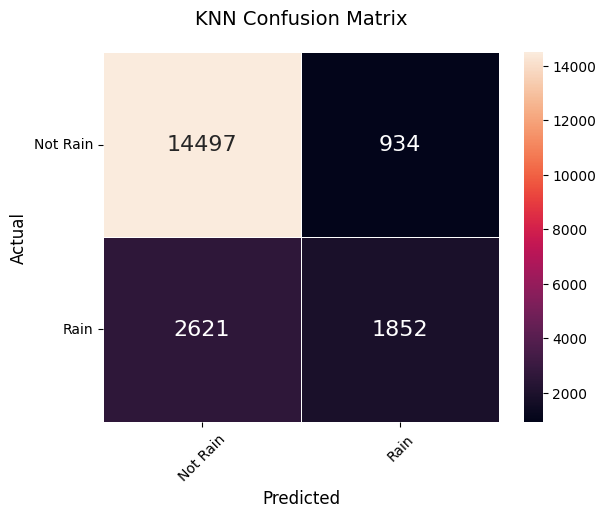

In [19]:
#KNN Confusion Matrix
y_pred = clf.predict(X_test)
conMat(y_test,y_pred,'KNN Confusion Matrix')

In [35]:
#=======
#Decision Tree Model
dtree_model = DecisionTreeClassifier()
#Training Model
dtree_model.fit(X_train, y_train)
#Testing accuracy
y_pred=dtree_model.predict(X_test)
dtree_model_score = accuracy_score(y_test, y_pred)
accuracy_dtree = round(dtree_model_score*100, 2)
print("The classification accuracy of Decision Tree model is "+ str(accuracy_dtree)+"%")
precision_dtree=round(precision_score(y_test,y_pred)*100,2)
recall_dtree=round(recall_score(y_test,y_pred)*100,2)
f1_dtree=round(f1_score(y_test,y_pred)*100,2)
print("The classification precision of Decision Tree model is "+ str(precision_dtree)+"%")
print("The classification recall of Decision Tree model is "+ str(recall_dtree)+"%")
print("The classification F1 of Decision Tree model is "+ str(f1_dtree)+"%")

The classification accuracy of Decision Tree model is 78.17%
The classification precision of Decision Tree model is 51.38%
The classification recall of Decision Tree model is 52.78%
The classification F1 of Decision Tree model is 52.07%


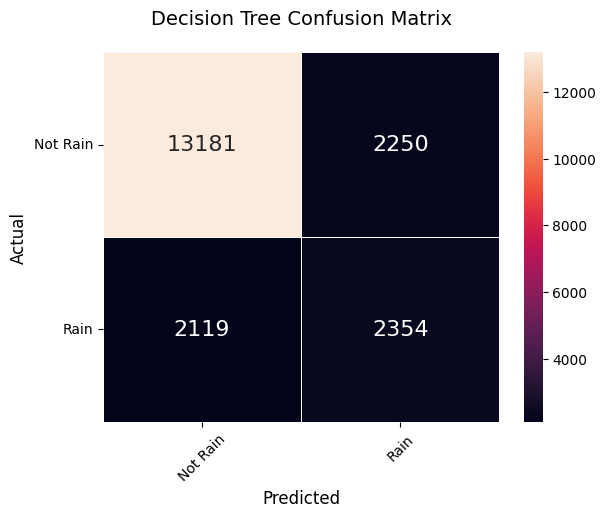

In [20]:
#Decision Tree Confusion Matrix
y_pred = dtree_model.predict(X_test)
conMat(y_test,y_pred,'Decision Tree Confusion Matrix')

In [50]:
#======
#Random Forest Model
rforest_model = RandomForestClassifier()
#Training
rforest_model.fit(X_train, y_train)
#Testing
y_pred=rforest_model.predict(X_test)
rforest_model_score = accuracy_score(y_test,y_pred)
accuracy_rforest = round(rforest_model_score*100, 2)
print("The classification accuracy of Random Forest model is "+ str(accuracy_rforest)+"%")
precision_rforest=round(precision_score(y_test,y_pred)*100,2)
recall_rforest=round(recall_score(y_test,y_pred)*100,2)
f1_rforest=round(f1_score(y_test,y_pred)*100,2)
print("The classification precision of Random Forest model is "+ str(precision_rforest)+"%")
print("The classification recall of Random Forest model is "+ str(recall_rforest)+"%")
print("The classification F1 of Random Forest model is "+ str(f1_rforest)+"%")


The classification accuracy of Random Forest model is 85.15%
The classification precision of Random Forest model is 75.56%
The classification recall of Random Forest model is 49.98%
The classification F1 of Random Forest model is 60.16%


In [59]:
test_weather=X_test
test_weather['rainfall']=y_pred
test_weather.to_csv('test_weather.csv')

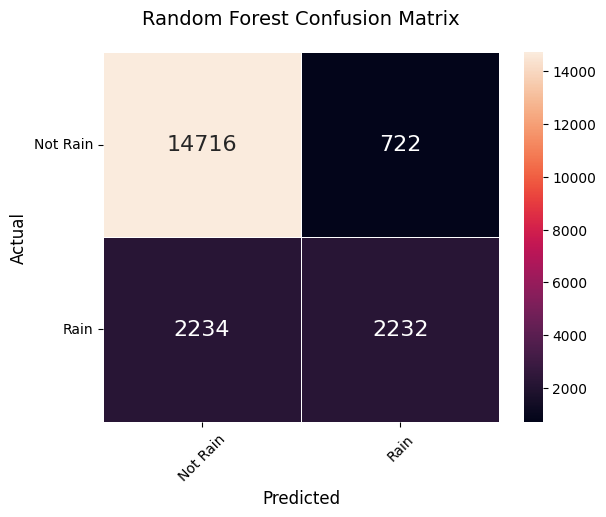

In [53]:
#Random Forest Confusion Matrix
y_pred = rforest_model.predict(X_test)
conMat(y_test,y_pred,'Random Forest Confusion Matrix')

In [ ]:
#======
#Support Vector Machine
#Create a svm Classifier
svm_clf = svm.SVC(kernel='linear') # Linear Kernel
#Train the model using the training sets
svm_clf.fit(X_train, y_train)
#Test
y_pred_svm = svm_clf.predict(X_test)
svm_score = accuracy_score(y_test, y_pred_svm)
accuracy_svm = round(svm_score*100, 2)
print("The classification accuracy of Support Vector Machine model is "+ str(accuracy_svm)+"%")
precision_svm=round(precision_score(y_test,y_pred_svm)*100,2)
recall_svm=round(recall_score(y_test,y_pred_svm)*100,2)
f1_svm=round(f1_score(y_test,y_pred_svm)*100,2)
print("The classification precision of Support Vector Machine model is "+ str(precision_svm)+"%")
print("The classification recall of Support Vector Machine model is "+ str(recall_svm)+"%")
print("The classification F1 of Support Vector Machine model is "+ str(f1_svm)+"%")


The classification accuracy of Support Vector Machine model is 83.92%


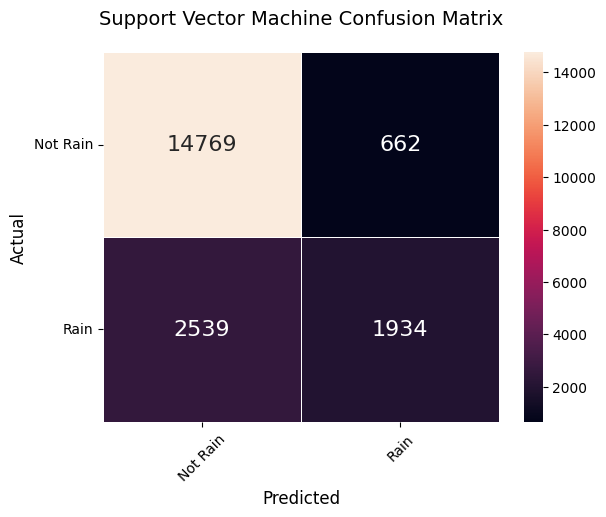

In [22]:
#Support Vector Machine Confusion Matrix
y_pred = svm_clf.predict(X_test)
conMat(y_test,y_pred,'Support Vector Machine Confusion Matrix')

In [13]:
#======
#Neural Network creating model with 4 hidden layers
Seq_model = keras.Sequential()
Seq_model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
Seq_model.add(Dense(128, activation='relu'))
Seq_model.add(Dense(64, activation='relu'))
Seq_model.add(Dense(32, activation='relu'))
Seq_model.add(Dense(8, activation='relu'))
Seq_model.add(Dense(1, activation='sigmoid'))
Seq_model.compile(loss= "binary_crossentropy" , optimizer="adam", metrics=["accuracy"])
Seq_model.summary()

/home/arramos/BYUI/CS 499/weather-rainfall-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-27 09:11:53.289623: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,297 (114.44 KB)

 Trainable params: 29,297 (114.44 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Train the model
history = Seq_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/30
797/797 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8121 - loss: 0.4238 - val_accuracy: 0.8378 - val_loss: 0.3818
Epoch 2/30
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8421 - loss: 0.3640 - val_accuracy: 0.8420 - val_loss: 0.3704
Epoch 3/30
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8431 - loss: 0.3630 - val_accuracy: 0.8450 - val_loss: 0.3622
Epoch 4/30
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8474 - loss: 0.3548 - val_accuracy: 0.8348 - val_loss: 0.3753
Epoch 5/30
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8461 - loss: 0.3545 - val_accuracy: 0.8432 - val_loss: 0.3658
Epoch 6/30
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8484 - loss: 0.3496 - val_accuracy: 0.8431 - val_loss: 0.3654
Epoch 7/30
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8487 - loss: 0.3479 - val_accuracy: 0.8447 - val_loss: 0.3602
Epoch 8/30
797/797 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8488 - loss: 0.3490 - val_accuracy: 0.

In [15]:
Seq_model_score = Seq_model.evaluate(X_test, y_test)
accuracy_neural_network = round(Seq_model_score[1]*100, 2)
print("The classification accuracy of Neural Network - Sequential model is "+ str(accuracy_neural_network)+"%")

622/622 ━━━━━━━━━━━━━━━━━━━━ 1s 829us/step - accuracy: 0.8470 - loss: 0.3597
The classification accuracy of Neural Network - Sequential model is 84.75%


In [36]:
#Neural Network Confusion Matrix
neural_network_prediction=Seq_model.predict(X_test)
y_pred_nn=[]
for n in neural_network_prediction:
    if n>0.5:
        y_pred_nn.append(1)
    else:
        y_pred_nn.append(0)
accuracy_nn = round(accuracy_score(y_test, y_pred_nn)*100,2)
precision_nn=round(precision_score(y_test,y_pred_nn)*100,2)
recall_nn=round(recall_score(y_test,y_pred_nn)*100,2)
f1_nn=round(f1_score(y_test,y_pred_nn)*100,2)
print("The classification accuracy of Neural Network model is "+ str(accuracy_nn)+"%")
print("The classification precision of Neural Network model is "+ str(precision_nn)+"%")
print("The classification recall of Neural Network model is "+ str(recall_nn)+"%")
print("The classification F1 of Neural Network model is "+ str(f1_nn)+"%")

622/622 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
The classification accuracy of Neural Network model is 84.75%
The classification precision of Neural Network model is 72.5%
The classification recall of Neural Network model is 51.8%
The classification F1 of Neural Network model is 60.43%


622/622 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


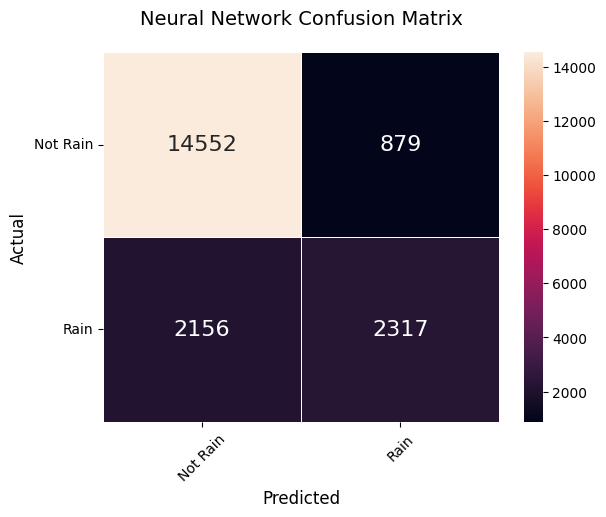

In [ ]:

conMat(y_test,y_pred_nn,'Neural Network Confusion Matrix')

In [37]:
#Model Comparison
model_score={}
model_score['KNN']=accuracy_knn
model_score['Decision Tree']=accuracy_dtree
model_score['Random Forest']=accuracy_rforest
model_score['SVM']=accuracy_svm
model_score['Neural Network']=accuracy_neural_network
#View as Table
model_table = pd.DataFrame(model_score, index = ["Scores"])
model_table.T

,Scores
KNN,82.14
Decision Tree,78.17
Random Forest,84.84
SVM,83.92
Neural Network,84.75


<Axes: >

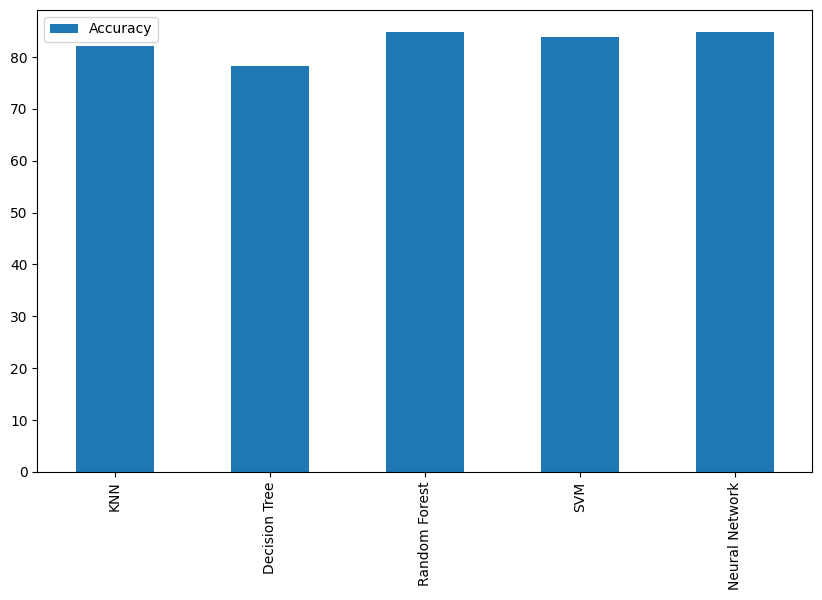

In [38]:
#View Graph
model_compare = pd.DataFrame(model_score, index = ["Accuracy"])
model_compare.T.plot.bar(figsize = (10, 6))

In [25]:
#Hyper Parameter for Random Forest
n_estimators = [100, 150, 200]
max_depth = [10, 15, 20]
criterion = ['gini', 'entropy']
bootstrap = [True,False]
random_state = [10, 20]
max_features = ['auto', 'sqrt']
min_samples_split = [1, 2, 3]
min_samples_leaf = [1, 2, 3]

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,
              criterion = criterion, bootstrap = bootstrap,
              random_state = random_state, max_features = max_features, 
              min_samples_split = min_samples_split,
              min_samples_leaf = min_samples_leaf)

randF = RandomizedSearchCV(rforest_model, hyperF, cv = 3, verbose = 1, n_jobs = -1)
bestF = randF.fit(X_train, y_train)
print("Results from Random Search ::" )
print("\nThe best estimator across ALL searched params:\n", randF.best_estimator_)
print("\nThe best parameters across ALL searched params:\n", randF.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/arramos/BYUI/CS 499/weather-rainfall-prediction/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
21 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/arramos/BYUI/CS 499/weather-rainfall-prediction/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/arramos/BYUI/CS 499/weather-rainfall-prediction/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/arramos/BYUI/CS 499/weather-rainfal

Results from Random Search ::

The best estimator across ALL searched params:
 RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_leaf=3,
                       min_samples_split=3, n_estimators=200, random_state=20)

The best parameters across ALL searched params:
 {'random_state': 20, 'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'gini', 'bootstrap': False}


In [26]:
#Accuracy of random forest with hyperparameters
rforest_model_hp = RandomForestClassifier(**randF.best_params_)
rforest_model_hp.fit(X_train, y_train)
rforest_model_hp_score = rforest_model_hp.score(X_test, y_test)
accuracy_rforst_hp = round(rforest_model_hp_score*100, 2)
print("The classification accuracy of Random Forest with Hyperparameters is "+ str(accuracy_rforst_hp)+"%")

The classification accuracy of Random Forest with Hyperparameters is 84.73%


In [27]:
#Hyperparameter for Neural Network
def model_builder(hp):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
     # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(10))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

In [29]:
#Configure tuner
tuner = kt.Hyperband(model_builder, # the hypermodel
                     objective='val_accuracy', # objective to optimize
max_epochs=10,
factor=3, # factor which you have seen above 
directory='dir', # directory to save logs 
project_name='khyperband')

#Searchin
stop_early = EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 28s]
val_accuracy: 0.8459461331367493

Best val_accuracy So Far: 0.8461345434188843
Total elapsed time: 00h 07m 13s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 480 and the optimal learning rate for the optimizer
is 0.001.



In [39]:
#Saving serialized model X 
joblib.dump(rforest_model, 'rainfall.mdl')

['rainfall.mdl']